In [18]:
import math
import pandas as pd
import scipy.constants as const
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
h = const.h  # Planck constant
c = const.c  # Speed of light
k = const.k  # Boltzmann constant
T = 5778  # Temperature of the Sun's surface in Kelvin


In [19]:
# Solar angle calculation functions
def solar_declination(day, hour):
    fracyear = 2 * math.pi / 365 * (day - 1 + (hour - 12) / 24)
    delta = math.degrees(0.006918 - 0.399912 * math.cos(fracyear) + 0.070257 * math.sin(fracyear) - 0.006758 * math.cos(2 * fracyear) + 0.000907 * math.sin(2 * fracyear) - 0.002697 * math.cos(3 * fracyear) + 0.00148 * math.sin(3 * fracyear))
    return delta

def calc_elevation_angle(day, hour, longitude=97.74, latitude=30.266666):
    h = hour + 6
    fracyear = 2 * math.pi / 365 * (day - 1 + (h - 12) / 24)
    eqtime = 229.17 * (0.000075 + 0.001868 * math.cos(fracyear) - 0.032077 * math.sin(fracyear) - 0.014615 * math.cos(2 * fracyear) - 0.040849 * math.sin(2 * fracyear))
    time_offset = eqtime - 4 * longitude
    tst = (h * 60 + time_offset) % 1440
    ha = math.radians(tst / 4 - 180) if tst < 720 else math.radians(tst / 4 - 180 - 360)
    delta = math.radians(solar_declination(day, h))
    zenith = math.degrees(math.acos(math.sin(math.radians(latitude)) * math.sin(delta) + math.cos(math.radians(latitude)) * math.cos(delta) * math.cos(ha)))
    psi = 90 - zenith
    return psi

def calc_air_mass_coefficient(elevation_angle):
    """
    Calculate the air mass coefficient using a simplified version of the Kasten-Young formula.
    This coefficient represents the path length that sunlight travels through the atmosphere.
    """
    if elevation_angle <= 0:
        return 0  # No sunlight during night or when the sun is below the horizon
    zenith_angle = 90 - elevation_angle
    zenith_angle_rad = math.radians(zenith_angle)
    return 1 / (math.cos(zenith_angle_rad) + 0.50572 * (96.07995 - zenith_angle)**(-1.6364))

def calc_adjusted_sunlight_intensity(solar_elevation_angle):
    """
    Adjust the sunlight intensity based on the solar elevation angle and atmospheric effects.
    """
    am_coefficient = calc_air_mass_coefficient(solar_elevation_angle)
    intensity_at_top_of_atmosphere = 1361  # Solar constant in W/m²
    concentration_factor = 2500 #from funnel rohan has math
    if am_coefficient == 0:
        return 0
    return intensity_at_top_of_atmosphere * concentration_factor * math.cos(math.radians(90 - solar_elevation_angle)) / am_coefficient


In [20]:
results = []
for day in range(1, 8): 
    for hour in range(24):
        declination_angle = solar_declination(day, hour)
        elevation_angle = calc_elevation_angle(day, hour)
        air_mass_coefficient = calc_air_mass_coefficient(elevation_angle)
        adjusted_sunlight_intensity = calc_adjusted_sunlight_intensity(elevation_angle)
  
        results.append([day, hour, declination_angle, elevation_angle, air_mass_coefficient, adjusted_sunlight_intensity])

df_results = pd.DataFrame(results, columns=["Day", "Hour", "Declination Angle", "Elevation Angle", "Air Mass Coeff", "Sunlight Intensity Post Intake"])
df_results.to_csv("output.csv")

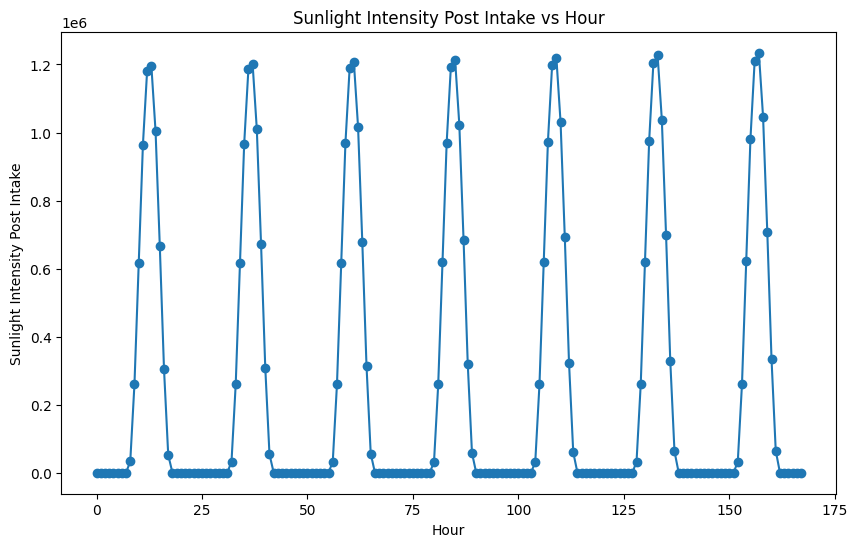

In [24]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(df_results.index, df_results['Sunlight Intensity Post Intake'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Sunlight Intensity Post Intake')
plt.title('Sunlight Intensity Post Intake vs Hour')

plt.savefig('Sunlight-Intensity-Post-Intake.png')
plt.show()